# Private Non-Renewable Resource Model

**Randall Romero Aguilar, PhD**

This demo is based on the original Matlab demo accompanying the  <a href="https://mitpress.mit.edu/books/applied-computational-economics-and-finance">Computational Economics and Finance</a> 2001 textbook by Mario Miranda and Paul Fackler.

Original (Matlab) CompEcon file: **demdp09.m**

Running this file requires the Python version of CompEcon. This can be installed with pip by running

    !pip install compecon --upgrade

<i>Last updated: 2021-Oct-01</i>
<hr>

## About

Profit maximizing mine owner must decide how much ore to extract

- States
     - s:  ore stock
- Actions
    - q: ore extracted and sold
- Parameters
    - a0,a1: demand function parameters
    - b0,b1: supply function parameters
    - $\delta$: discount factor

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from compecon import BasisSpline, DPmodel, DPoptions, qnwnorm, demo

### Model parameters

In [2]:
a0, a1, b0, b1, δ = 5, 0.8, 7, 1.0, 0.9

### State space
The state variable is s="Stock", which is restricted to $s\in[0, 10]$. 

Here, we represent it with a cubic spline basis, with $n=101$ nodes.

In [3]:
n, smin, smax = 101, 0, 10
basis = BasisSpline(n, smin, smax, labels=['Ore Stock'])

### Action space
The choice variable q="Ore extracted" must be nonnegative.

In [4]:
def bounds(s, i=None, j=None):
    return np.zeros_like(s), s[:]

### Reward function
The reward function is the utility of harvesting $q$ units.

In [5]:
def reward(s, q, i=None, j=None):
    u = (a0-b0+b1*s)*q - (a1+b1/2)*q**2
    ux = (a0-b0+b1*s) - (2*a1+b1)*q
    uxx = -2*(a1+b1/2)*np.ones_like(s)    
    return u, ux, uxx

### State transition function
Next period, the stock will be equal that is $s' = \alpha (s-q) - 0.5\beta(s-q)^2$

In [6]:
def transition(s, q, i=None, j=None, in_=None, e=None):
    g = s-q
    gx = -np.ones_like(s)
    gxx = np.zeros_like(s)
    return g, gx, gxx

### Model structure
The value of wealth $s$ satisfies the Bellman equation
\begin{equation*}
V(s) = \max_q\left\{(a_0-b_0+b_1 s)q - (a_1+b_1/2)q^2 + \delta V(s')  \right\}
\end{equation*}

To solve and simulate this model,use the CompEcon class `DPmodel`

In [7]:
model = DPmodel(basis, reward, transition, bounds,
                       x=['Ore Extracted'],
                       discount=δ)

### Solving the model

Solving the growth model by collocation

In [8]:
S = model.solve()
S.head()

Solving infinite-horizon model collocation equation by Newton's method
iter change       time    
------------------------------
   0       1.9e+01    0.0189
   1       3.5e+00    0.0349
   2       2.2e-01    0.0489
   3       1.0e-03    0.0629
   4       2.2e-08    0.0738
   5       1.9e-14    0.0808
Elapsed Time =    0.08 Seconds


,Ore Stock,value,resid,Ore Extracted
Ore Stock,,,,
0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
0.009911,0.009911,-3.725252e-16,-3.725252e-17,3.016346e-15
0.019822,0.019822,-3.915019e-16,-3.915019e-17,3.170001e-15
0.029732,0.029732,-1.557981e-16,-1.557981e-17,1.261501e-15
0.039643,0.039643,2.357181e-16,2.357181e-17,-1.908615e-15


`DPmodel.solve` returns a pandas `DataFrame` with the following data:

Compute and print abandonment point

In [9]:
sstar = (b0-a0)/b1
print(f'Abandonment Point = {sstar:5.2f}')

Abandonment Point =  2.00


We are also interested in the shadow price of ore (the first derivative of the value function).

In [10]:
S['shadow price'] = model.Value(S['Ore Stock'],1)

## Plotting the results

### Optimal Policy

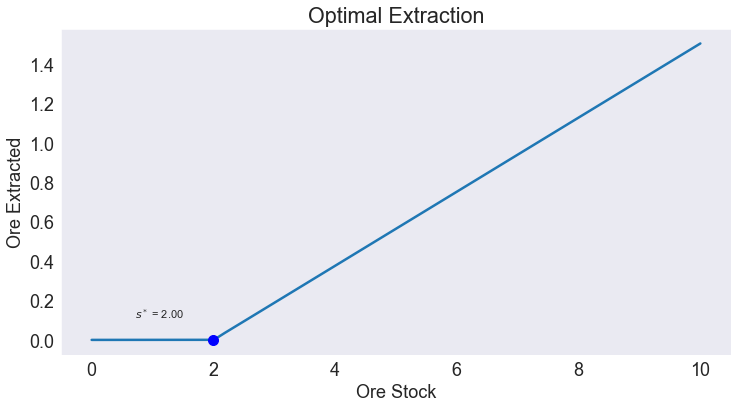

In [11]:
fig1 = demo.figure('Optimal Extraction','Ore Stock', 'Ore Extracted')
plt.plot(S['Ore Extracted'])
demo.annotate(sstar, 0,f'$s^*$ = {sstar:.2f}','bo', (-8, +8),ms=10,fs=11)

### Value Function

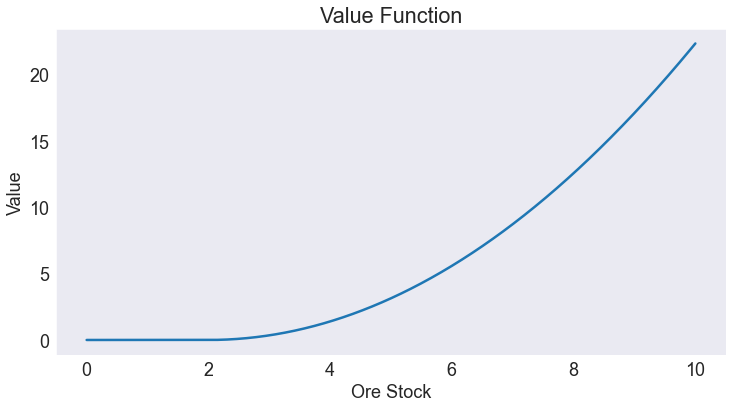

In [12]:
fig2 = demo.figure('Value Function', 'Ore Stock', 'Value')
plt.plot(S.value)

### Shadow Price Function

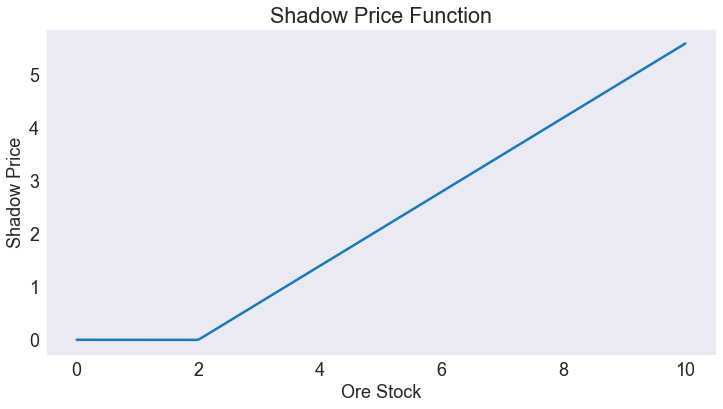

In [13]:
fig3 = demo.figure('Shadow Price Function', 'Ore Stock', 'Shadow Price')
plt.plot(S['shadow price'])

### Residual

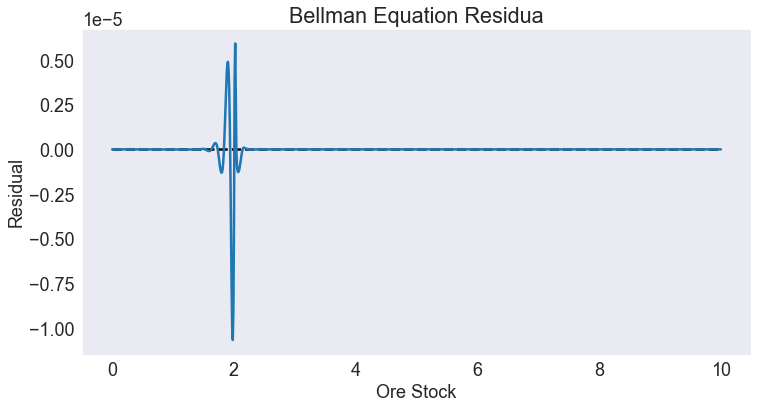

In [14]:
fig4 = demo.figure('Bellman Equation Residua', 'Ore Stock', 'Residual')
plt.hlines(0,smin,smax,'k',linestyles='--')
plt.plot(S['resid'])
plt.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))

## Simulating the model

We simulate 21 periods of the model starting from $s=s_{\max}$

In [15]:
T = 21
data = model.simulate(T, smax)

In [16]:
data.columns

Index(['time', 'Ore Stock', 'Ore Extracted'], dtype='object')

### Simulated State and Policy Paths

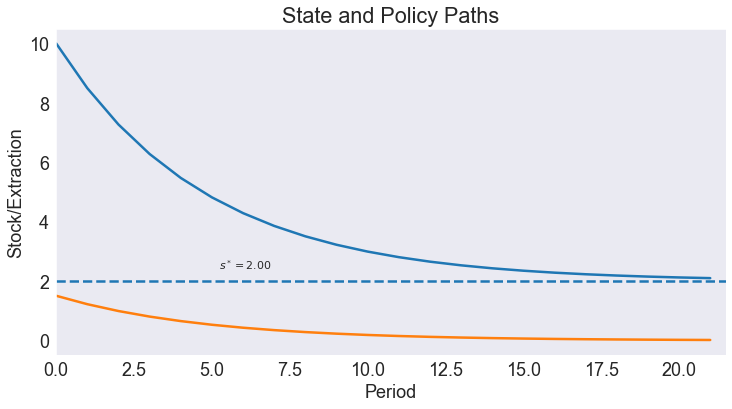

In [17]:
fig5 = demo.figure('State and Policy Paths','Period', 'Stock/Extraction',[0, T + 0.5])
plt.plot(data[['Ore Stock', 'Ore Extracted']])
plt.hlines(sstar,*plt.xlim(), linestyle='--')
demo.annotate(5, sstar, f'$s^* = {sstar:.2f}$',ms=0,fs=11)
#demo.annotate(T, qstar, f'steady-state extraction\n = {qstar:.2f}', **opts)

In [18]:
#demo.savefig([fig1,fig2,fig3,fig4,fig5])